In [1]:
# 1. Coin Flip Example
#Import required libraries :
import math
import random
import numpy as np

import scipy as sp

import matplotlib.pyplot as plt
# import PillowWriter
from matplotlib.animation import PillowWriter

from matplotlib.animation import FuncAnimation
import pymc as pm

%matplotlib notebook

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [24]:
# To get PMF from CDF : 
# P(X = k) = P(X <= k) - P(X <= k - 1)

def bernoulli_pmf(k, p):
    # k is numer of successes
    # p is probability of success
    return p ** k * (1 - p) ** (1 - k)

def bernoulli_cdf(k, p):
    # sum of pmf from 0 to k
    # k is inclusive
    return sum([bernoulli_pmf(i, p) for i in range(k + 1)])

def bernoulli_rv(p):
    return random.choices([0, 1], weights=[1 - p, p])[0]


def binomial_pmf(k, n, p):
    # k is number of successes
    # n is number of trials
    # p is probability of success
    # n chosen k
    n_choose_k = math.factorial(n) / (math.factorial(k) * math.factorial(n - k))

    return n_choose_k * (p ** k) * ((1 - p) ** (n - k))

def binomial_cdf(k, n, p):
    # sum of pmf from 0 to k
    # k is inclusive
    # n is number of trials
    # p is probability of success
    return sum([binomial_pmf(i, n, p) for i in range(k + 1)])


def binom_rv(n, p):
    
    return sum(random.choices([0, 1], weights=[1 - p, p], k=n))


def geometric_pmf(k, p):
    # k is number of failures
    # p is probability of success
    return (1 - p) ** (k - 1) * p

def geometric_cdf(k, p):
    # sum of pmf from 0 to k
    # k is inclusive
    return sum([geometric_pmf(i, p) for i in range(k + 1)])

def geometric_rv(p):
    return random.choices(range(1, 1000), weights=[geometric_pmf(i, p) for i in range(1, 1000)])[0]

def poisson_pmf(k, l):
    # k is number of events
    # l is rate of events
    return (l ** k) * (math.e ** (-l)) / math.factorial(k)

def poisson_cdf(k, l):
    # sum of pmf from 0 to k
    # k is inclusive
    return sum([poisson_pmf(i, l) for i in range(k + 1)])

def poisson_rv(l):
    return random.choices(range(0, 1000), weights=[poisson_pmf(i, l) for i in range(0, 1000)])[0]



In [22]:
print(bernoulli_cdf(1, 0.5))

1.0


In [338]:
rvars_manual = [binom_rv(10, 0.5) for i in range(10)]

rvars_manual

[4, 3, 3, 5, 5, 5, 6, 5, 3, 3]

In [339]:
rvars = sp.stats.binom.rvs(10, 0.5, size=10)

rvars



array([5, 6, 4, 5, 7, 8, 7, 5, 3, 5], dtype=int64)

In [310]:
def coin_flip():
    return random.randint(0,1)

def roll_dice():
    return random.randint(1,6)



In [315]:
# coin flip 10 times

sp.stats.bernoulli.rvs(0.5, size=10)

array([1, 0, 0, 0, 0, 1, 1, 1, 0, 0], dtype=int64)

In [488]:
def coin_flip_experiment(n):

    # Initial assumptions for the experiment
    # 1. The coin is fair
    # 2. The coin is tossed n times
    # 3. The coin is tossed independently of each other
    # 4. Bernoulli distribution is used to simulate the coin toss

    events = sp.stats.bernoulli.rvs(p=0.5, size=n, random_state=42)
    res = 0
    prob = []
    std_dev = []
    variences = []

    for inx, event in enumerate(events):
        res = res + event
        prob_ = res / (inx + 1)
        prob.append(prob_)
        variences.append(prob_ * (1 - prob_))
        std_dev.append(np.sqrt(prob_ * (1 - prob_)))


    # Plotting the results
    fig, ax = plt.subplots()
    ax.set_ylim(-0.2, 1)
    ax.set_xlim(0, len(prob))
    ax.set_xlabel('Number of simulations')
    ax.set_ylabel('Probability')

    line, = ax.plot([], [], lw=2, label='Probability / E(x)')
    std_dev_line, = ax.plot([], [], lw=2, color='red', label='Standard Deviation')
    variences_line, = ax.plot([], [], lw=2, color='green', label='Variance')

    # Animation function
    def prob_update(num):
        x = range(0, num)
        mean_ = prob[:num]
        std_dev_ = std_dev[:num]
        var_ = variences[:num]
        line.set_data(x, mean_)
        std_dev_line.set_data(x, std_dev_)
        variences_line.set_data(x, var_)
        return line, std_dev_line

    ax.legend()
    anim = FuncAnimation(fig, prob_update, frames=np.arange(1, len(prob)+1), repeat=False)
    plt.xlabel('Number of coin flips')
    plt.ylabel('Probability of getting heads')
    plt.title('Coin Flip Simulation')
    anim.save('coin_flip.gif', writer=PillowWriter(fps=10))

    return events, prob, std_dev, variences

def coin_flip_experiment_all(n, iters):

    # Initial assumptions for the experiment
    # 1. The coin is fair
    # 2. The coin is tossed n times
    # 3. The coin is tossed independently of each other
    # 4. Bernoulli distribution is used to simulate the coin toss

    def coin_experiment(nums):
        events = sp.stats.bernoulli.rvs(p=0.5, size=nums)
        res = 0
        prob = []
        std_dev = []
        variences = []

        for inx, event in enumerate(events):
            res = res + event
            prob_ = res / (inx + 1)
            prob.append(prob_)
            variences.append(prob_ * (1 - prob_))
            std_dev.append(np.sqrt(prob_ * (1 - prob_)))
        return prob

    
    # Animation function
    def prob_update(num, experiments, lines):
        for experiment, line in zip(experiments, lines):
            x = range(0, num)
            mean_ = experiment[:num]
            line.set_data(x, mean_)
        return lines


    experiments = [coin_experiment(n) for i in range(iters)]

    # Plotting the results
    fig, ax = plt.subplots()
    ax.set_ylim(0, 1)
    ax.set_xlim(0, n)
    ax.set_xlabel('Number of simulations')
    ax.set_ylabel('Probability')

    lines = [ax.plot([], [], lw=2)[0] for _ in experiments]

    ax.legend()

    anim = FuncAnimation(fig, prob_update, n, fargs=(experiments, lines), repeat=False)
    plt.xlabel('Number of coin flips')
    plt.ylabel('Probability of getting heads')
    plt.title('Coin Flip Simulation')
    anim.save('coin_flip.gif', writer=PillowWriter(fps=20))






In [491]:
coin_flip_experiment_all(3000, 100)

<IPython.core.display.Javascript object>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [419]:
# MC simulation
prob_list = []
def monte_carlo(n):
    # n = number of simulations
    # x = number of heads
    results = 0
    for i in range(n):
        flip_result = coin_flip()
        # print("Coin result on experiment {}: {} ".format(i,flip_result))
        results = results + flip_result 
        # print("Total number of heads: {}".format(results))      

        prob_value = results/ (i+1)
        # print("Probability of heads: {}".format(prob_value))
        prob_list.append(prob_value)

        # plot the results
        plt.axhline(y=0.5, color='red', linestyle='dashed')
        plt.xlabel('Number of simulations')
        plt.ylabel('Probability')
        plt.title('Monte Carlo Simulation')
        plt.plot(prob_list)
    return prob_value/n
    

"""Algos
Given a set of coin flip data, you can estimate the distribution parameters (in this case, the probability of getting heads)
 using maximum likelihood estimation (MLE). MLE is a method for estimating the parameters of a statistical model given a set of data."""



 Method of Moments (MOM): This method estimates the parameters of a distribution by equating the sample moments (i.e., mean, variance, skewness, etc.) to the theoretical moments of the distribution.

Maximum a posteriori estimation (MAP): This method is similar to MLE, but it incorporates prior information about the parameters into the estimation process. It uses Bayes' theorem to find the parameter values that maximize the posterior probability distribution.

Bayesian estimation: This method is based on Bayesian statistics and uses prior information about the parameters in combination with the data to estimate the parameters. It allows for the calculation of the probability distribution of the parameters rather than a single point estimate.

In [446]:
coin_data_5, p, st = coin_flip_experiment(10)


<IPython.core.display.Javascript object>

MovieWriter imagemagick unavailable; using Pillow instead.


In [448]:
coin_data_5, p, st

(array([1, 0, 0, 0, 0, 0, 0, 1, 0, 1], dtype=int64),
 [1.0,
  0.5,
  0.3333333333333333,
  0.25,
  0.2,
  0.16666666666666666,
  0.14285714285714285,
  0.25,
  0.2222222222222222,
  0.3],
 [0.0,
  0.5,
  0.4714045207910317,
  0.4330127018922193,
  0.4,
  0.37267799624996495,
  0.3499271061118826,
  0.4330127018922193,
  0.41573970964154905,
  0.458257569495584])

In [434]:
n = len(coin_data_5)
k = sum(coin_data_5)

def likelihood(p):
    return p**k * (1-p)**(n-k)

prior_p = 0.5

result = sp.optimize.minimize(lambda p: -likelihood(p), prior_p, method='Nelder-Mead')

In [440]:
p_est = result.x[0]
print("Estimated parameter p(mean):", p_est)
print("Estimated (std):", np.sqrt(p_est*(1-p_est)/n))
print("Estimated parameter std  :", result)

Estimated parameter p(mean): 0.19999999999999973
Estimated (std): 0.1788854381999831
Estimated parameter std  :  final_simplex: (array([[0.2       ],
       [0.20009766]]), array([-0.08192   , -0.08191999]))
           fun: -0.08191999999999999
       message: 'Optimization terminated successfully.'
          nfev: 28
           nit: 14
        status: 0
       success: True
             x: array([0.2])


In [437]:
observed = [k, n-k]
expected = [n*p_est, n*(1-p_est)]

In [438]:
# Chi-squared test
chisq, p_value = sp.stats.chisquare(observed, expected)
print("Chi-squared test statistic:", chisq)
print("p-value:", p_value)

Chi-squared test statistic: 2.5637979419682905e-30
p-value: 0.9999999999999987


In [367]:
def poisson_pmf(k, lam):
    # where k is the number of events
    
    return (lam ** k) * (math.e ** (-lam)) / math.factorial(k)


print("Poisson PMF: {}".format(poisson_pmf(1, 0.000008)))


Poisson PMF: 7.999936000256e-06


In [399]:
# average rate of button breakage
lam = 1/1000

# create a Poisson distribution object with the estimated lambda
poisson_dist = sp.stats.poisson(lam)

# calculate the probability mass function for a specific number of failures
k = 5
poisson_dist.pmf(k)

# generate random variables from the poisson distribution
poisson_dist.rvs(size=10)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [379]:
X_fails = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
lbda = 1/100

In [380]:
poisson_pd = sp.stats.poisson.pmf(X_fails, lbda)


In [381]:
for i in poisson_pd:
    print("{:.8f}".format(i))

0.99004983
0.00990050
0.00004950
0.00000017
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000
0.00000000


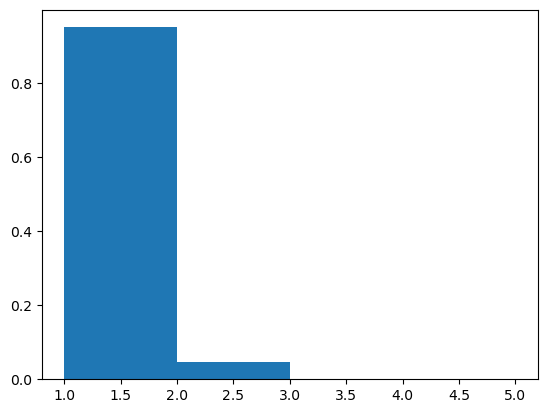

In [397]:
plt.hist(x_, bins=[1,2,3,4, 5], density=True)
plt.show()


In [7]:
print(dice_experiment())

[4, 1]


In [ ]:
# Gerald -> ask about Internal data

# Intervals instead of events 

# then assumption : all valves are same and collectors same

# All collectors overlaped 

In [160]:
class Valve:
    def __init__(self, name, collector):
        self.name = name
        self.collector = collector
    def __repr__(self):
        return self.name

    @staticmethod
    def get_failure(dist='possion'):
        if dist == 'possion':
            return sp.stats.poisson.rvs(mu=600, loc=400)


class Collector:
    def __init__(self, name, valves):
        self.name = name
        self.valves = valves

    def __repr__(self):
        return self.name


In [161]:
random.randint(30,100)

73

In [255]:
valve_one = Valve('Valve 1', 'Collector 1')


In [256]:
v_one_failures = []
v_two_failures = []
v_three_failures = []
v_four_failures = []
f_count = 0

In [257]:

while f_count < 10000:

    valve_one_f = valve_one.get_failure()
    valve_two_f = valve_one.get_failure()
    valve_three_f = valve_one.get_failure()
    valve_four_f = valve_one.get_failure()

    f_count += min(valve_one_f, valve_two_f, valve_three_f, valve_four_f)
    print(f_count)
    
    one_before_f = np.zeros(f-1) 
    one_wait_f = np.ones(random.randint(50,200))

    v_one_ts = np.concatenate((one_before_f, one_wait_f))
    
    v_one_failures = np.concatenate((v_one_ts, v_one_failures))

966
1960
2899
3877
4875
5858
6855
7844
8796
9771
10724


In [290]:
sp.stats.poisson.pmf(1, 1)

0.36787944117144233

In [252]:
poss_rvs = sp.stats.poisson.rvs(mu=500, loc=500, size=5000)

beta_dist = sp.stats.beta(a=0.7, b=0.3, loc=0, scale=100)

In [253]:
xx = beta_dist.rvs(size=10)

In [254]:
xx

array([62.24250849, 99.59050868, 99.9993372 , 76.05178449, 98.91809208,
       96.45916403, 97.09124664, 59.97611683, 94.80691935, 65.04972237])

In [251]:
beta_dist.pdf(90)


0.007896020013656035

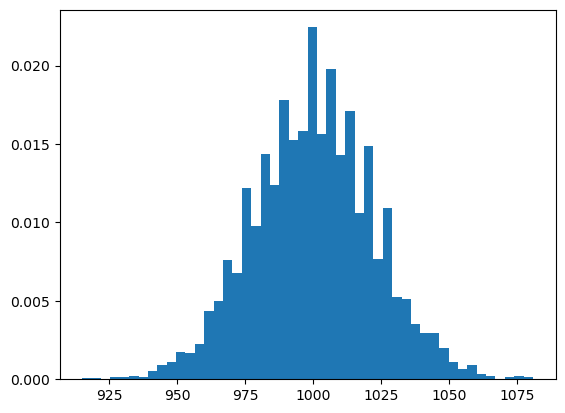

In [188]:
plt.hist(poss_rvs, bins='auto', density=True)
plt.show()

In [115]:
one_half = np.zeros(f-1) 
second_half = np.ones(31)

valve_half = np.zeros(f2-1)
valve_half2 = np.ones(31)

xs = np.concatenate((one_half, second_half))
xss = np.concatenate((valve_half, valve_half2))

con_ = np.concatenate((xs, xss))

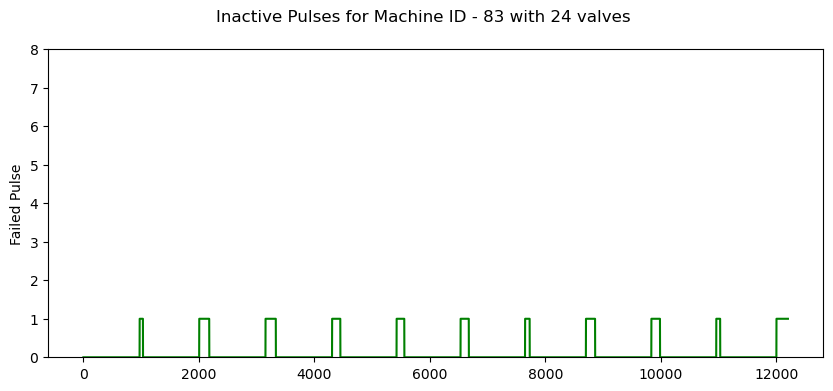

In [237]:
fig,ax = plt.subplots(figsize=(10,4), sharex=True)
# title
fig.suptitle("Inactive Pulses for Machine ID - 83 with 24 valves")
ax.set_ylim([0, 8])
ax.set_ylabel("Failed Pulse", color="black", fontsize=10)
ax.plot(v_one_failures, color='green')


In [180]:
o = np.ones(10)
b = np.ones(5)

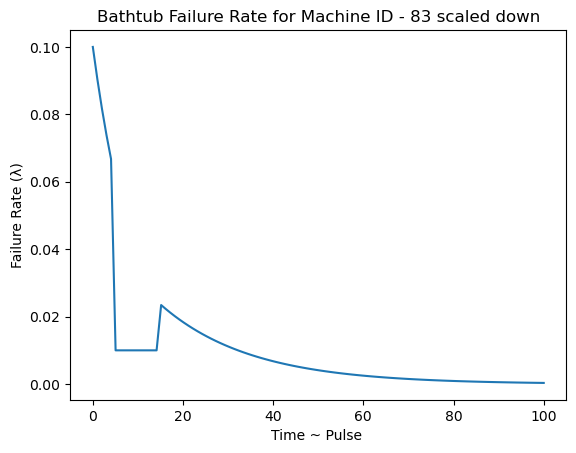

In [309]:
import numpy as np
import matplotlib.pyplot as plt

def bathtub_pdf(t, λ1, λ2, λ3, t1, t2):
    if t < t1:
        return λ1*np.exp(-λ1*t)
    elif t1 <= t <= t2:
        return λ2
    elif t > t2:
        return λ3*np.exp(-λ3*t)
    else:
        return None

# Example usage:
t = np.linspace(0, 100, 100)
λ1, λ2, λ3 = 0.1, 0.01, 0.05
t1, t2 = 5, 15
y = [bathtub_pdf(x, λ1, λ2, λ3, t1, t2) for x in t]

plt.plot(t, y)
plt.title('Bathtub Failure Rate for Machine ID - 83 scaled down')
plt.xlabel('Time ~ Pulse ')
plt.ylabel('Failure Rate (λ)')
plt.show()


In [307]:
np.linspace(0, 10)

array([ 0.        ,  0.20408163,  0.40816327,  0.6122449 ,  0.81632653,
        1.02040816,  1.2244898 ,  1.42857143,  1.63265306,  1.83673469,
        2.04081633,  2.24489796,  2.44897959,  2.65306122,  2.85714286,
        3.06122449,  3.26530612,  3.46938776,  3.67346939,  3.87755102,
        4.08163265,  4.28571429,  4.48979592,  4.69387755,  4.89795918,
        5.10204082,  5.30612245,  5.51020408,  5.71428571,  5.91836735,
        6.12244898,  6.32653061,  6.53061224,  6.73469388,  6.93877551,
        7.14285714,  7.34693878,  7.55102041,  7.75510204,  7.95918367,
        8.16326531,  8.36734694,  8.57142857,  8.7755102 ,  8.97959184,
        9.18367347,  9.3877551 ,  9.59183673,  9.79591837, 10.        ])